In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F


#np.set_printoptions(precision=4)
import math
from utils import *

nS = 30
nA = 2
seed = get_current_seed()
#seed = 47146882006333120128184314011326542902
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, small=5, large=1000, seed=seed)
tau = 1.
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)
tmdp_1 = TMDP(river, xi, tau=.5, gamma=gamma, seed=seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Current seed for result reproducibility: 270317059938223899479376270491901942650


In [2]:
q_c = np.zeros((nS, nA))
tmdp.update_tau(.99)
cur_res = curriculum_AC(tmdp, q_c, alpha = 0.08, alpha_pol = 0.03, episodes=1500000, 
                        batch_nS=12, temperature=5., biased=False, lam=0, 
                        epochs=1, use_delta_Q=False, final_temperature=1)


No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 566 length: 12 #teleports:554
Time for bound evaluation:  0.16314268112182617
No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 1338 length: 13 #teleports:759
Time for bound evaluation:  0.00400090217590332
No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 2217 length: 12 #teleports:867
Time for bound evaluation:  0.003000497817993164
[(1, 0.99), (0.0, 0.98945), (1.0, 0.98945)]
Alpha*: 1.0 tau*: 0.98945 Episode: 3375 length: 12 #teleports:1146
Got not null reward 5.0!
Time for bound evaluation:  0.004001617431640625
[(0.0, 0.9889), (1.0, 0.9889)]
Alpha*: 0.0 tau*: 0.9889 Episode: 4751 length: 12 #teleports:1364
Time for bound evaluation:  0.003999948501586914
[(0.0, 0.98833), (1.0, 0.98833)]
Alpha*: 0.0 tau*: 0.98833 Episode: 5979 length: 12 #teleports:1216
Time for bound evaluation:  0.004001140594482422
[(1, 0.98833), (0.0, 0.98772), (1.0, 0.98773)]
Alpha*: 1.0 tau*: 0.98773 Episode: 

In [3]:
print(get_softmax_policy(cur_res["thetas"][-1]))
print(cur_res["Qs"][-1])
print(get_policy(cur_res["thetas"][-1]))

[[1.00000000e+00 4.22169514e-30]
 [1.00000000e+00 3.63075451e-27]
 [1.00000000e+00 7.35601513e-26]
 [1.00000000e+00 7.22918281e-24]
 [1.00000000e+00 1.44617651e-21]
 [1.00000000e+00 5.96429193e-20]
 [1.00000000e+00 5.97825478e-18]
 [1.00000000e+00 6.64166146e-16]
 [1.00000000e+00 3.76910930e-14]
 [1.00000000e+00 3.02347093e-12]
 [1.00000000e+00 1.90837307e-10]
 [9.99999991e-01 9.05698989e-09]
 [9.99999658e-01 3.41865388e-07]
 [9.99994684e-01 5.31635967e-06]
 [9.99947921e-01 5.20785217e-05]
 [9.99413955e-01 5.86044932e-04]
 [9.96288977e-01 3.71102285e-03]
 [9.82605573e-01 1.73944267e-02]
 [9.40013390e-01 5.99866096e-02]
 [7.65223627e-01 2.34776373e-01]
 [1.13074035e-01 8.86925965e-01]
 [1.12621407e-05 9.99988738e-01]
 [8.64344930e-15 1.00000000e+00]
 [5.11746173e-28 1.00000000e+00]
 [1.83582027e-43 1.00000000e+00]
 [2.01660807e-58 1.00000000e+00]
 [1.31158181e-64 1.00000000e+00]
 [1.92162256e-71 1.00000000e+00]
 [1.37310926e-78 1.00000000e+00]
 [1.05746137e-62 1.00000000e+00]]
[[ 49.999

In [4]:
res = bellman_optimal_q(mdp.env.P_mat, mdp.env.reward, mdp.gamma)
Q = res["Q"]
print(Q)
d = compute_d_from_tau(mdp.env.mu, mdp.env.P_mat, mdp.xi, get_policy(Q), mdp.gamma, 0.)
d_curr = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_softmax_policy(cur_res["thetas"][-1]), tmdp.gamma, 0.)
d_q = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_policy(q_c), tmdp.gamma, 0.)

delta_pol = get_policy(Q)-get_policy(get_softmax_policy(cur_res["thetas"][-1]))
print(delta_pol)
V = compute_V_from_Q(Q, get_softmax_policy(cur_res["thetas"][-1]))
r_s_a = compute_r_s_a(mdp.env.P_mat, mdp.env.reward)

j_opt = compute_j(r_s_a, get_policy(Q), d, mdp.gamma)
j_curr = compute_j(r_s_a, get_policy(get_softmax_policy(cur_res["thetas"][-1])), d_curr, tmdp.gamma)
j_q_curr = compute_j(r_s_a, get_policy(q_c), d_q, tmdp.gamma)
j_exp = compute_expected_j(V, tmdp.env.mu)
print("optimal performance: ",j_opt)
print("expected performance: ",j_exp)
print("curriculum performance: ", j_curr)
print("Q curriculum performance: ",j_q_curr)

[[ 49.99999551  43.64999596]
 [ 44.99999596  39.73499632]
 [ 40.49999636  35.76149669]
 [ 36.44999673  32.18534702]
 [ 32.80499705  28.96681232]
 [ 29.52449735  26.07013109]
 [ 26.57204761  23.46311798]
 [ 23.91484285  21.11680618]
 [ 21.52335857  19.00512556]
 [ 19.37102271  17.10461301]
 [ 17.43392044  15.39415171]
 [ 15.6905284   13.85473653]
 [ 14.12147556  12.46926288]
 [ 12.709328    11.22233659]
 [ 11.4383952   10.10010293]
 [ 10.29455568   9.09009264]
 [  9.26510011   8.56956516]
 [  8.3385901    9.77741159]
 [  8.79967043  13.56944612]
 [ 12.21250151  19.85917894]
 [ 17.87326104  29.31100849]
 [ 26.37990764  43.31754787]
 [ 38.98579308  64.02993099]
 [ 57.62693789  94.64884833]
 [ 85.1839635  139.91028348]
 [125.91925513 206.81605235]
 [186.13444711 305.7165135 ]
 [275.14486215 451.91167249]
 [406.72050524 668.0180859 ]
 [601.21627731 987.46766315]]
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0

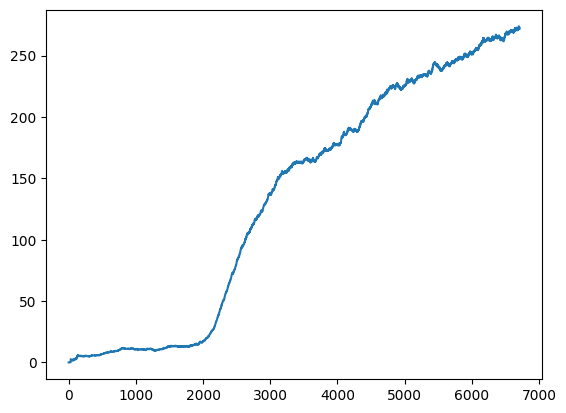

In [5]:
import matplotlib.pyplot as plt
reward_records = cur_res["reward_records"]
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 500:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-499:idx+1]
    average_reward.append(np.average(avg_list)/12)
# Plot
#plt.plot(reward_records)
plt.plot(average_reward)